This notebook continues the analysis from 'graphite_rod_2.ipynb' and implements some other ideas to improve the temperature calculations. This includes changing the initial value for temperature and emissiivty coefficients, averaging frames over time to even out internal fluctuations in the rod, and analyzing the data without correcting it to the white and dark references.

# Imports

In [1]:
from spectral import imshow, view_cube
import spectral.io.envi as envi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from sklearn.linear_model import LinearRegression
from numpy.polynomial import Polynomial, polynomial
import time
from tqdm.notebook import tqdm

# https://doi.org/10.1063/5.0019847 imports
import algorithm.generate_spectrum as gs
from algorithm.pixel_operations import choose_pixels, generate_combinations
from algorithm.temperature_functions import optimum_temperature
from algorithm.kfold import order_selection
from scipy.interpolate import splrep, splev, UnivariateSpline

# constants
h = 6.626e-34 # Planck's constant
c = 299792458 # Speed of light
k = 1.380649e-23 # Boltzmann constant
b = 2.89777e-3 # Wien's displacement law constant

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Opening Data

In [2]:
# opening the raw data from its ENVI file and header
dark_ref = envi.open('graphite_rod_2/darkReference.hdr', 'graphite_rod_2/darkReference.raw')
white_ref = envi.open('graphite_rod_2/whiteReference.hdr', 'graphite_rod_2/whiteReference.raw')
data_ref = envi.open('graphite_rod_2/raw.hdr', 'graphite_rod_2/raw.raw')

# converting the data to a tensor as a NumPy array
white_tensor = np.array(white_ref.load())
dark_tensor = np.array(dark_ref.load())
data_tensor = np.array(data_ref.load())

# correcting tensor with references and displaying tensor as an image
corrected_data = np.divide(
    np.subtract(data_tensor, dark_tensor),
    np.subtract(white_tensor, dark_tensor))

/Users/namanparikh/opt/anaconda3/envs/openmsi/lib/python3.9/site-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


<Figure size 640x480 with 0 Axes>

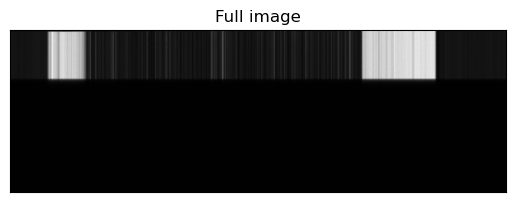

<Figure size 640x480 with 0 Axes>

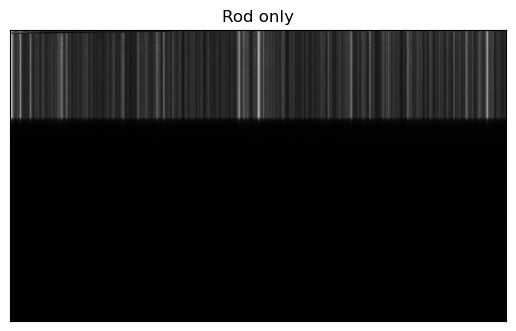

<Figure size 640x480 with 0 Axes>

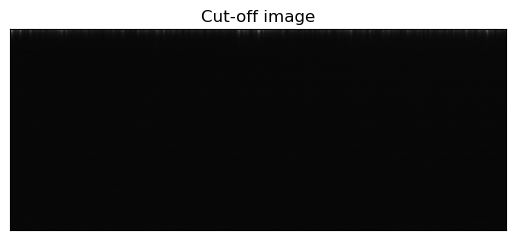

In [3]:
# displaying data
plt.figure()
imshow(corrected_data, (100,100,100))
plt.title("Full image")
plt.xticks([])
plt.yticks([])
plt.show()

# displaying data
plt.figure()
imshow(corrected_data[:,240:1130,:], (100,100,100))
plt.title("Rod only")
plt.xticks([])
plt.yticks([])
plt.show()

cut_data = corrected_data[163:,240:1130:,:]
plt.figure()
imshow(cut_data, (100,100,100))
plt.title("Cut-off image")
plt.xticks([])
plt.yticks([])
plt.show()

In [4]:
# reading hdr file
file = open("raw.hdr", 'r')
text = file.read()

# parsing for wavelength values and units
start_id = "\nwavelength = {\n"
start_index = text.find(start_id) + len(start_id)
end_id = "\n}\n;AOI height"
end_index = text.find(end_id)
wavelengths = text[start_index:end_index]
wavelengths = np.array(wavelengths.split("\n,"), dtype="float32")
units_id = "wavelength units = "
units_index = text.find(units_id) + len(units_id)
units = text[units_index:text.find(start_id)]
# print(f"Units = {units}")
# print(f"Number wavelengths = {len(wavelengths_arr)}")
# print(f"Wavelengths: {wavelengths_arr}")

### Blurring Image

In [5]:
def compress_horiz_slice(data, start_idx, end_idx):
    return np.array([np.divide(np.sum(data[:,start_idx:end_idx,:],axis=1), 
                     end_idx-start_idx)])

def shrink_image(image, quiet=False):
    for itera in range(2):
        horiz_slices = []
        for i in range(image.shape[1] // 10):
            start_idx = i * 10
            end_idx = (i + 1) * 10
            if end_idx < image.shape[1]:
                horiz_slices.append(compress_horiz_slice(image, start_idx, end_idx))
            else:
                horiz_slices.append(compress_horiz_slice(image, start_idx, image.shape[1]))
                
        image = np.concatenate(tuple(horiz_slices), axis=0)

    return image

ImageView object:
  Display bands       :  [0, 185.5, 370]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.14107884466648102, 0.31228071451187134]
    G: [-0.0009084302582778037, 0.4164927303791046]
    B: [-0.023099133744835854, 1.5]

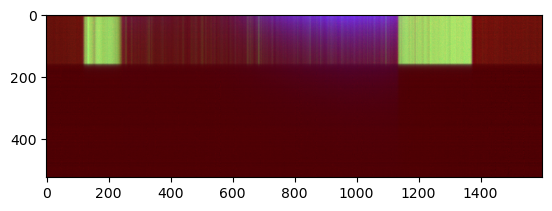

In [9]:
imshow(corrected_data)

ImageView object:
  Display bands       :  [0, 185.5, 370]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.007208522409200668, 0.17295554280281067]
    G: [-8.721157792024314e-05, 0.3744051456451416]
    B: [-0.0015350270550698042, 1.3876392841339111]

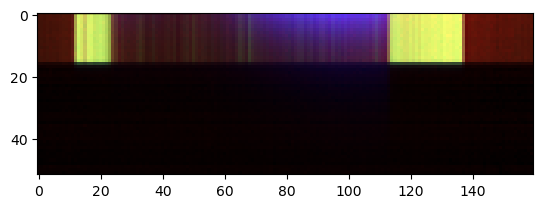

In [10]:
imshow(shrink_image(corrected_data))

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.0013388462830334902, 0.25555044412612915]
    G: [-0.0013388462830334902, 0.25555044412612915]
    B: [-0.0013388462830334902, 0.25555044412612915]

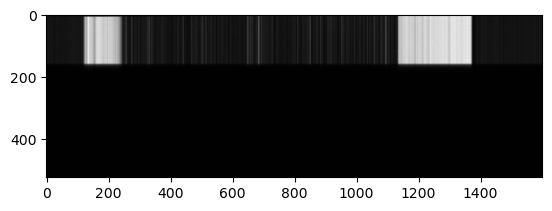

In [12]:
imshow(corrected_data, (100,100,100))

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-7.521725638071075e-05, 0.22883589565753937]
    G: [-7.521725638071075e-05, 0.22883589565753937]
    B: [-7.521725638071075e-05, 0.22883589565753937]

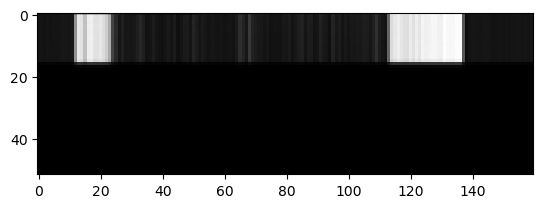

In [11]:
imshow(shrink_image(corrected_data), (100,100,100))

# Pyrometry Setup

In [5]:
# l: wavelength, T: temperature, e: emissivity, offset: constant offset to account for stray light in the data
def blackbody(l, T, e, offset):
    return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset

def quiet_fit(wl, data, intensity, params0):
    
    def residuals(params):
        result = []
        for i in range(len(wl)):
            Si = intensity(params, wl[i] * 1e-9)
            St = data[i]
            result.append(Si - St)
        return np.array(result)

    result = least_squares(residuals, params0)
    return result

# Some Spectra

We can see that this spectrum has lots of noise at both low and high wavelengths. This is particulraly troublesome for this analysis because the high wavelenghts are the most important part of the spectrum for the fitting, meaning we will not get a good fitting.

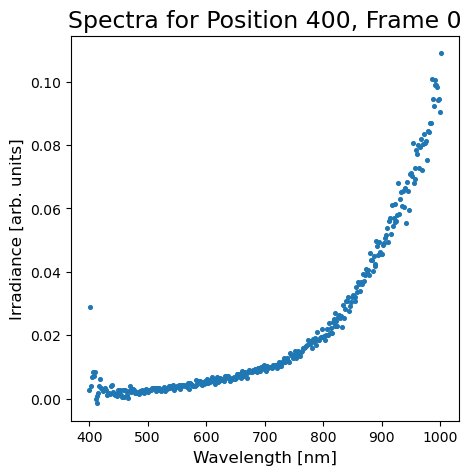

In [10]:
plt.figure(figsize=(5,5))
plt.scatter(wavelengths, cut_data[:,400,:][0], s=7)
plt.title("Spectra for Position 400, Frame 0", fontsize=17)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Irradiance [arb. units]", fontsize=12)
# plt.yticks([])
plt.show()

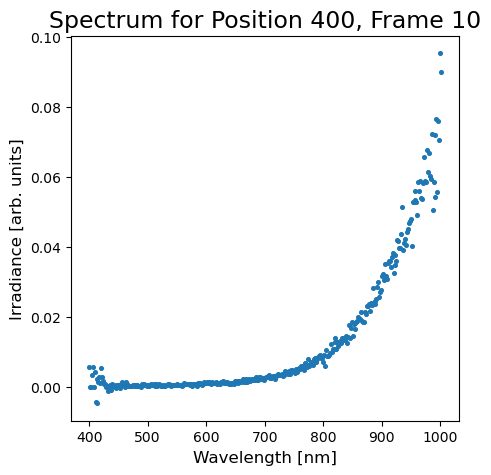

In [11]:
plt.figure(figsize=(5,5))
plt.scatter(wavelengths, cut_data[:,400,:][10], s=7)
plt.title("Spectrum for Position 400, Frame 10", fontsize=17)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Irradiance [arb. units]", fontsize=12)
# plt.yticks([])
plt.show()

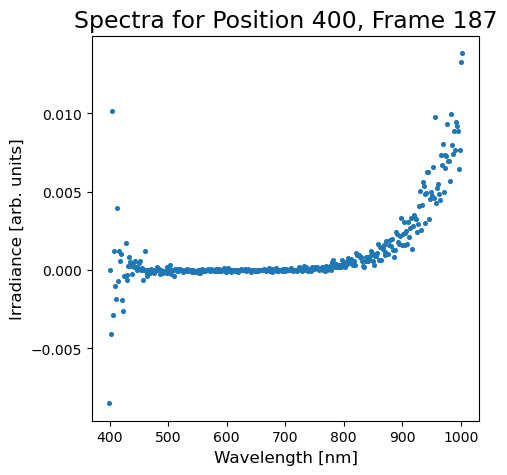

In [12]:
plt.figure(figsize=(5,5))
plt.scatter(wavelengths, cut_data[:,400,:][187], s=7)
plt.title("Spectra for Position 400, Frame 187", fontsize=17)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Irradiance [arb. units]", fontsize=12)
# plt.yticks([])
plt.show()

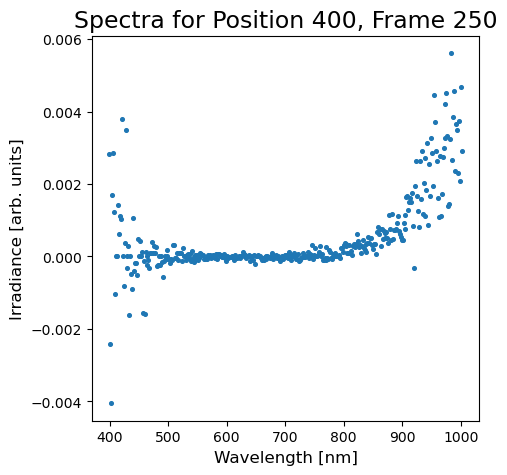

In [13]:
plt.figure(figsize=(5,5))
plt.scatter(wavelengths, cut_data[:,400,:][250], s=7)
plt.title("Spectra for Position 400, Frame 250", fontsize=17)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Irradiance [arb. units]", fontsize=12)
# plt.yticks([])
plt.show()

# Full Row Analyses

## Standard

In [49]:
wl = wavelengths
row = cut_data[:,400,:]

  0%|          | 0/360 [00:00<?, ?it/s]

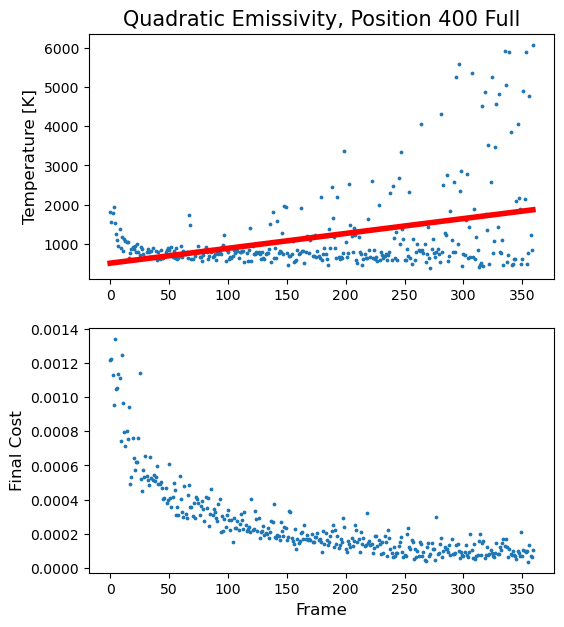

In [45]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0.1, 1000])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Full", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

## Changing Initial Guesses

In [ ]:
wl = wavelengths
row = cut_data[:,400,:]

  0%|          | 0/360 [00:00<?, ?it/s]

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_14171/2706764598.py:3: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


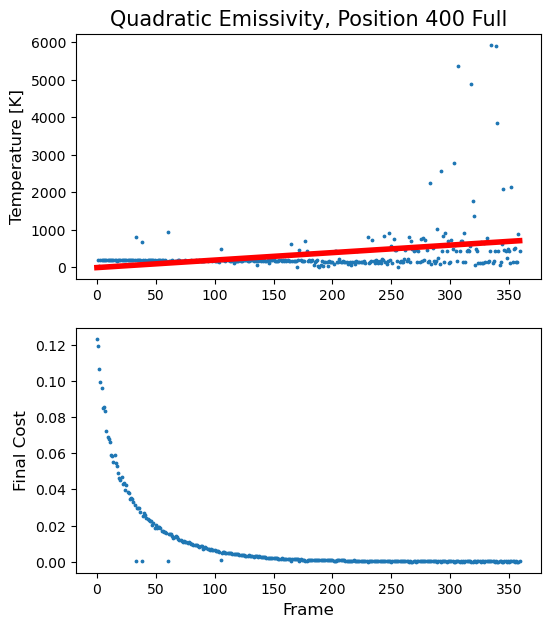

In [50]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0.1, 500])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Full", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

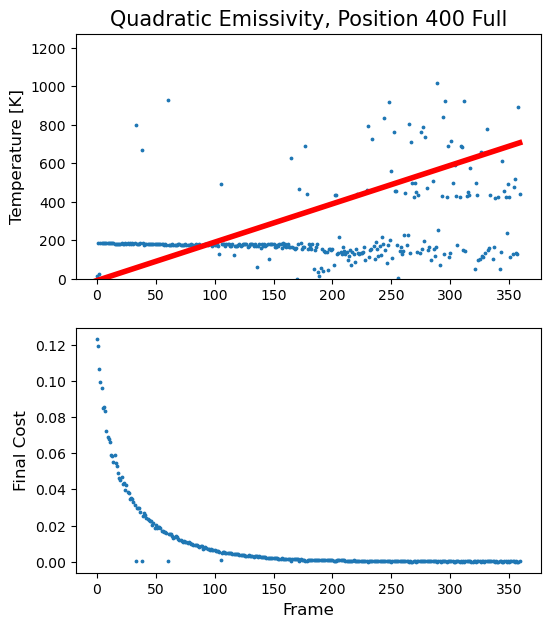

In [51]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Full", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1273])

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

In [64]:
wl = wavelengths
row = cut_data[:,400,:]

  0%|          | 0/360 [00:00<?, ?it/s]

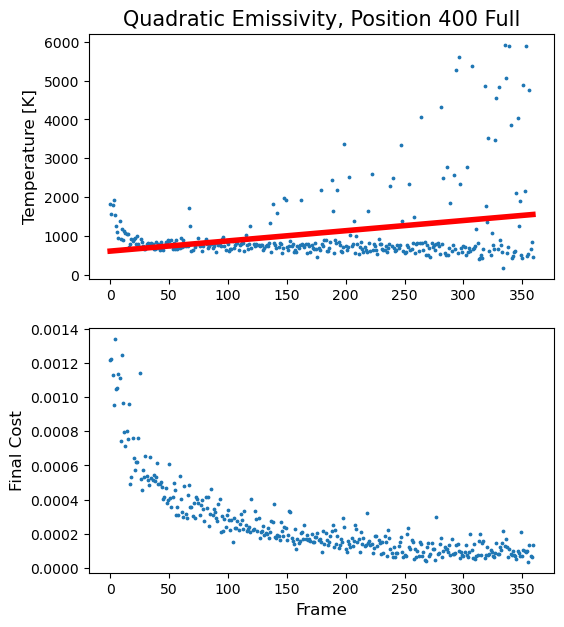

In [66]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 400])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Full", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

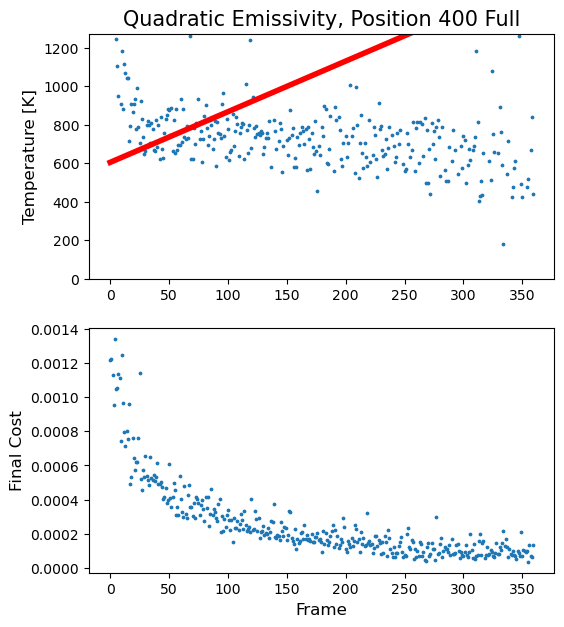

In [67]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Full", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1273])

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

# Averaging Every 10 Frames

## Averaging Spectrum

In [6]:
def compress(data, slice_len):
    retval = []
    for iter in range(data.shape[0] // slice_len):
        start_idx = iter * slice_len
        end_idx = (iter + 1) * slice_len
        retval.append(np.divide(sum(data[start_idx:end_idx]), slice_len))
    return np.array(retval)

In [7]:
compressed_data = compress(cut_data, 10)

### Position 0

In [8]:
row = compressed_data[:,0,:]
wl = wavelengths

#### Quadratic Emissivity

  0%|          | 0/36 [00:00<?, ?it/s]

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized



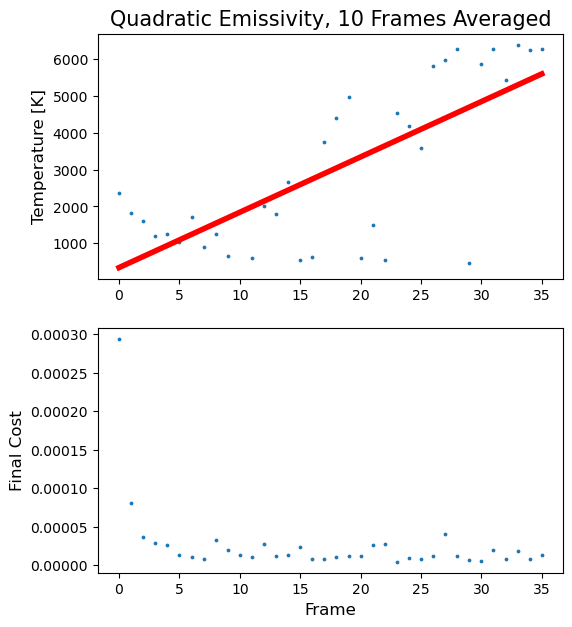

In [9]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0.1, 1000])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, 10 Frames Averaged", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

#### Linear Emissivity

  0%|          | 0/36 [00:00<?, ?it/s]

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_14171/2706764598.py:3: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


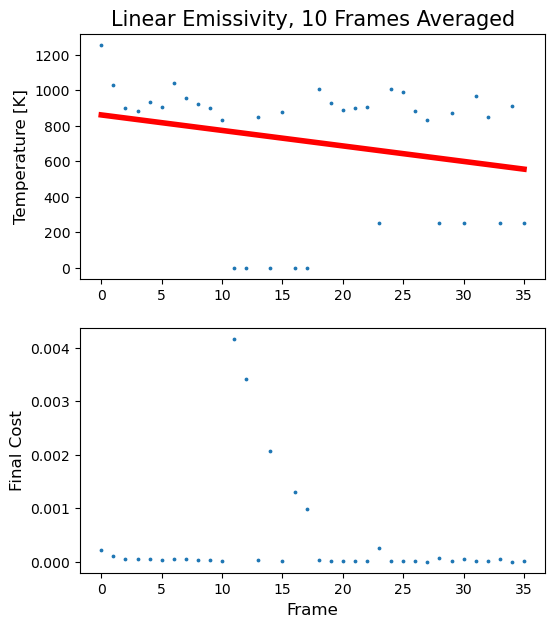

In [29]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 0.1, 1000])
    def intensity(params, l):
        e = params[0] + (params[1] * l)
        return blackbody(l, params[3], e, params[2])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Linear Emissivity, 10 Frames Averaged", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

### Position 400

In [30]:
row = compressed_data[:,400,:]
wl = wavelengths

#### Quadratic Emissivity

  0%|          | 0/36 [00:00<?, ?it/s]

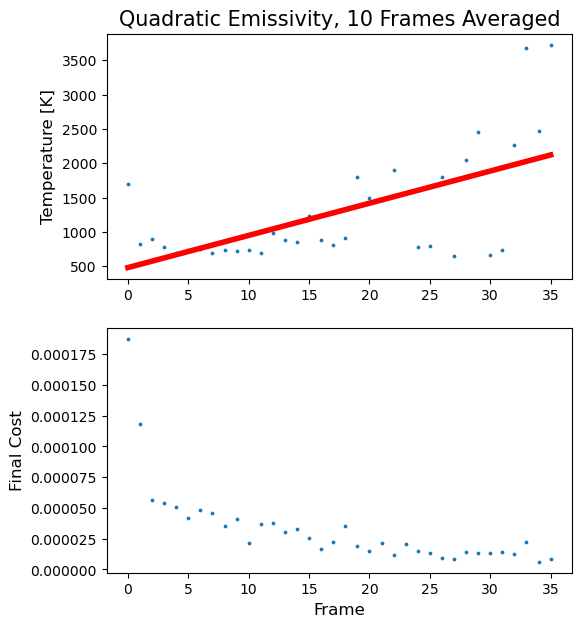

In [27]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0.1, 1000])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, 10 Frames Averaged", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

#### Linear Emissivity

  0%|          | 0/36 [00:00<?, ?it/s]

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_14171/2706764598.py:3: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


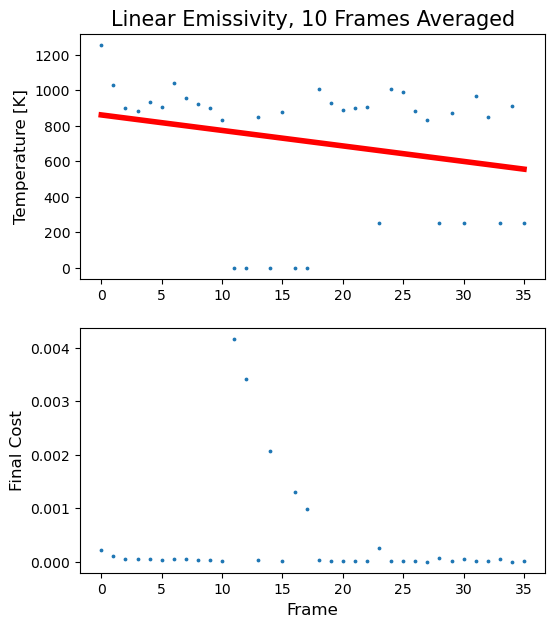

In [31]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 0.1, 1000])
    def intensity(params, l):
        e = params[0] + (params[1] * l)
        return blackbody(l, params[3], e, params[2])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Linear Emissivity, 10 Frames Averaged", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

## Averaging Temps

### Position 0

In [15]:
row = cut_data[:,0,:]
wl = wavelengths

  0%|          | 0/360 [00:00<?, ?it/s]

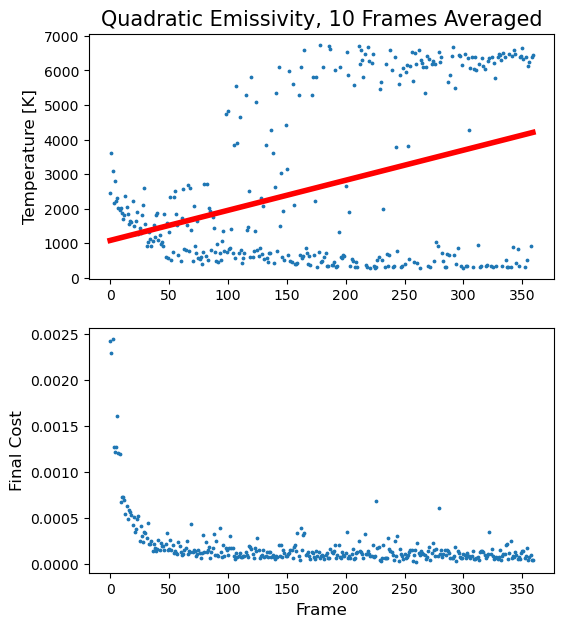

In [16]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0.1, 1000])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, 10 Frames Averaged", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

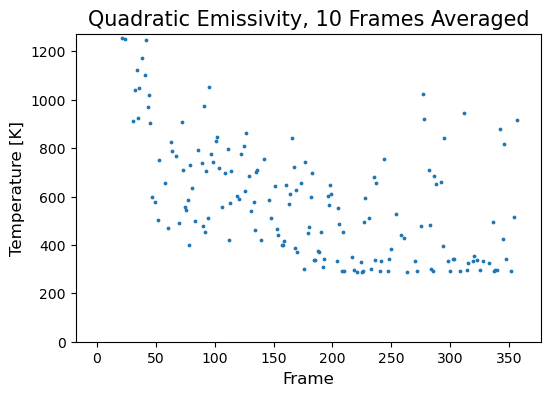

In [25]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(4)
ax.set_title("Quadratic Emissivity, 10 Frames Averaged", fontsize=15)

ax.scatter(x, Ts, s=3)
ax.set_ylabel("Temperature [K]", fontsize=12)
ax.set_ylim([0, 1273])
ax.set_xlabel("Frame", fontsize=12)

plt.show()

### Position 400

In [ ]:
row = cut_data[:,400,:]
wl = wavelengths

In [ ]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0.1, 1000])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, 10 Frames Averaged", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

# Individual Pixels

In [32]:
def curve_fit(wl, data, intensity, params0):
    
    def residuals(params):
        result = []
        for i in range(len(wl)):
            Si = intensity(params, wl[i] * 1e-9)
            St = data[i]
            result.append(Si - St)
        return np.array(result)

    result = least_squares(residuals, params0)
    print(f"Optimal parameters: {result.x}\nFinal Cost: {result.cost}\nTermination Status: {result.status}")

    yfit = []
    for l in wl:
        yfit.append(intensity(result.x, l * 1e-9))

    plt.figure(figsize=(5,5))
    plt.scatter(wl, data, s=5)
    plt.scatter(wl, yfit, s=5)
    plt.title("Non-linear least squares regression", fontsize=15)
    plt.xlabel("Wavelength [nm]", fontsize=12)
    plt.xticks(fontsize=10)
    plt.ylabel("Intensity [arb. units]", fontsize=12)
    plt.yticks([])
    plt.legend(["Actual", "Fitted"], fontsize=10)
    plt.show()

    return result

## Bunch of Frames

### Position 400, Frame 20

Optimal parameters: [ 4.64781873e-08 -3.75454343e-02 -2.64873841e-01  2.89521960e-04
  8.62170583e+02]
Final Cost: 0.000643233790646402
Termination Status: 3


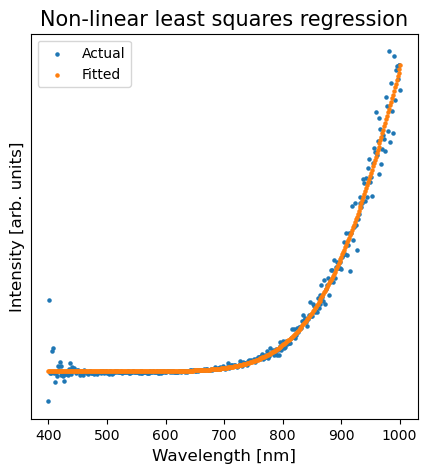

In [37]:
wl = wavelengths
data = cut_data[:,400,:][20]

# params = [a0, a1, a2, offset, T]
params0 = np.array([1, 1, 1, 0.1, 1000])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

_ = curve_fit(wl, data, intensity, params0)

### Position 400, Frame 25

Optimal parameters: [ 2.30842965e-05 -4.41687834e+01  2.14553222e+07  2.59691112e-04
  7.05767656e+02]
Final Cost: 0.0011428475660463361
Termination Status: 2


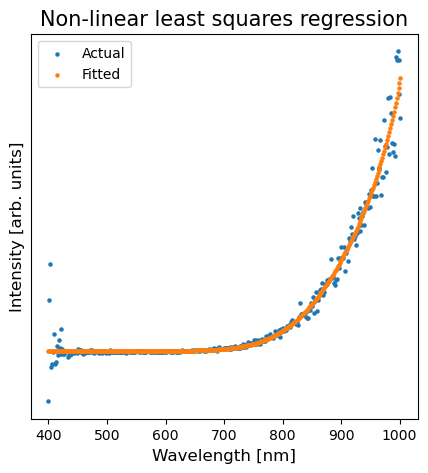

In [39]:
wl = wavelengths
data = cut_data[:,400,:][25]

# params = [a0, a1, a2, offset, T]
params0 = np.array([1, 1, 1, 0.1, 1000])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

_ = curve_fit(wl, data, intensity, params0)

### Position 400, Frame 30

Optimal parameters: [ 9.69369959e-05 -1.86561355e+02  9.07403845e+07  1.57560849e-04
  6.66141491e+02]
Final Cost: 0.0006559284697186842
Termination Status: 2


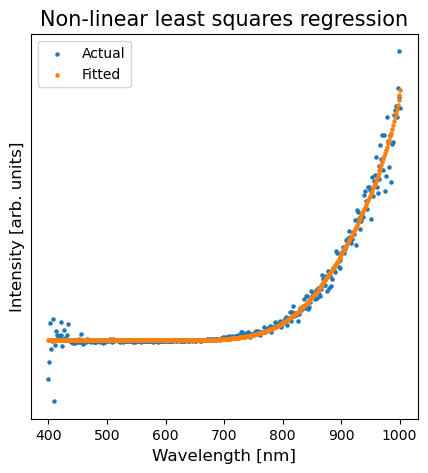

In [40]:
wl = wavelengths
data = cut_data[:,400,:][30]

# params = [a0, a1, a2, offset, T]
params0 = np.array([1, 1, 1, 0.1, 1000])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

_ = curve_fit(wl, data, intensity, params0)

### Position 400, Frame 35

Optimal parameters: [ 4.63602208e-07 -8.08137999e-01  3.68470234e+05 -2.81763085e-06
  8.06766529e+02]
Final Cost: 0.0005284224296168163
Termination Status: 2


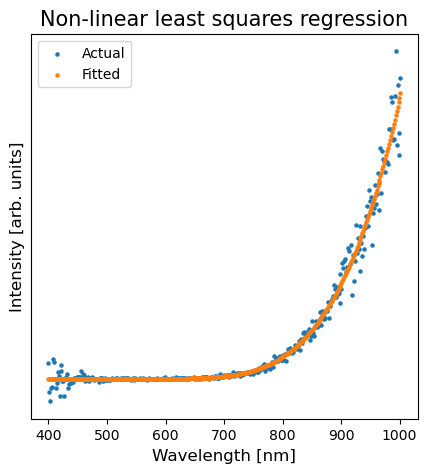

In [41]:
wl = wavelengths
data = cut_data[:,400,:][35]

# params = [a0, a1, a2, offset, T]
params0 = np.array([1, 1, 1, 0.1, 1000])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

_ = curve_fit(wl, data, intensity, params0)

## Changing Initial Guess

Optimal parameters: [ 3.32497020e-12  2.10857445e-02 -1.71791471e+04  2.82346294e-04
  9.07082851e+02]
Final Cost: 0.0006430443849942757
Termination Status: 2


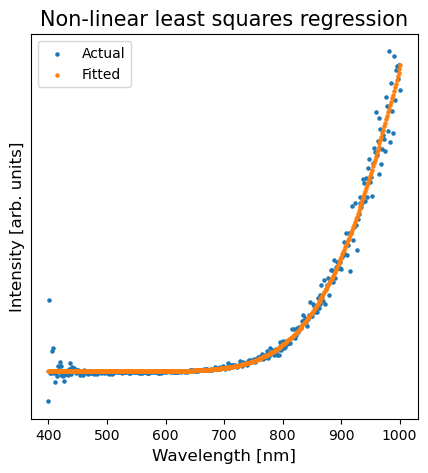

In [60]:
wl = wavelengths
data = cut_data[:,400,:][20]

# params = [a0, a1, a2, offset, T]
params0 = np.array([1, 1, 1, 0, 400])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

_ = curve_fit(wl, data, intensity, params0)

Optimal parameters: [ 2.57822485e-01 -2.56669902e+05  1.52911518e+04  2.78852293e-05
  4.24658672e+02]
Final Cost: 7.014163937441358e-05
Termination Status: 1


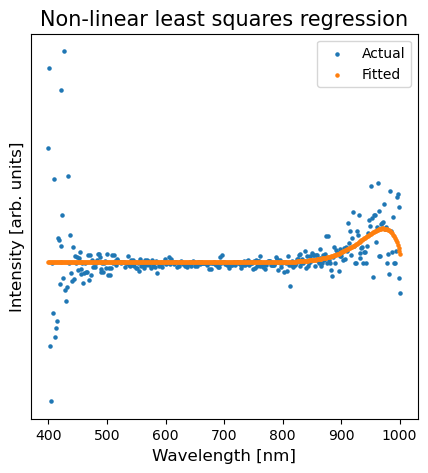

In [62]:
wl = wavelengths
data = cut_data[:,400,:][350]

# params = [a0, a1, a2, offset, T]
params0 = np.array([1, 1, 1, 0, 400])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

_ = curve_fit(wl, data, intensity, params0)

Optimal parameters: [ 9.57551634e-08 -7.98365722e-02  3.05351335e+00 -1.10569330e-05
  7.41471212e+02]
Final Cost: 0.00011132774855898627
Termination Status: 2


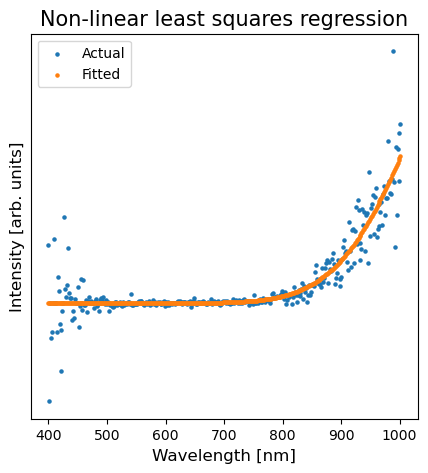

In [63]:
wl = wavelengths
data = cut_data[:,400,:][200]

# params = [a0, a1, a2, offset, T]
params0 = np.array([1, 1, 1, 0, 400])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

_ = curve_fit(wl, data, intensity, params0)

# Without Correction

## Image

<Figure size 640x480 with 0 Axes>

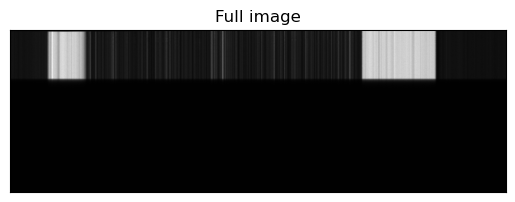

<Figure size 640x480 with 0 Axes>

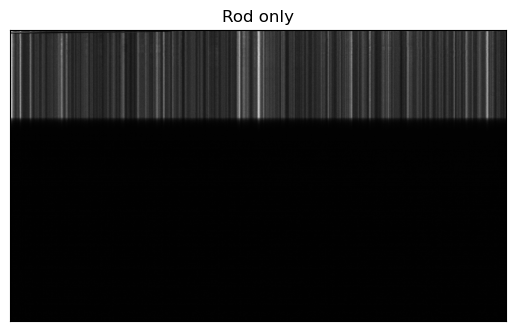

<Figure size 640x480 with 0 Axes>

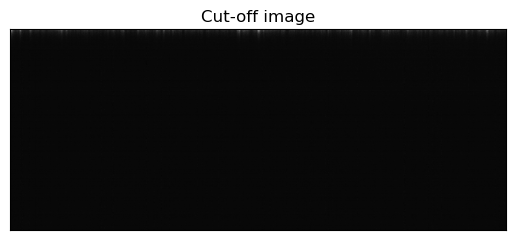

In [14]:
# displaying data
plt.figure()
imshow(data_tensor, (100,100,100))
plt.title("Full image")
plt.xticks([])
plt.yticks([])
plt.show()

# displaying data
plt.figure()
imshow(data_tensor[:,240:1130,:], (100,100,100))
plt.title("Rod only")
plt.xticks([])
plt.yticks([])
plt.show()

cut_data = data_tensor[163:,240:1130:,:]
plt.figure()
imshow(cut_data, (100,100,100))
plt.title("Cut-off image")
plt.xticks([])
plt.yticks([])
plt.show()

## Some Spectra

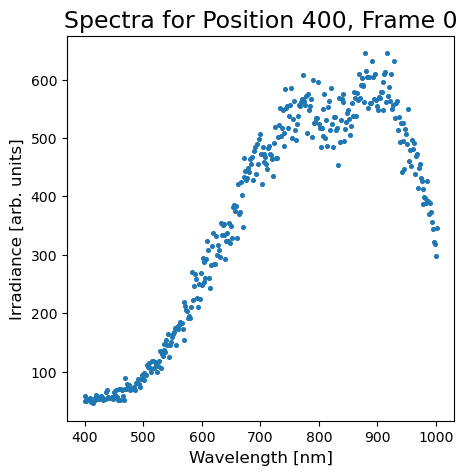

In [15]:
plt.figure(figsize=(5,5))
plt.scatter(wavelengths, cut_data[:,400,:][0], s=7)
plt.title("Spectra for Position 400, Frame 0", fontsize=17)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Irradiance [arb. units]", fontsize=12)
# plt.yticks([])
plt.show()

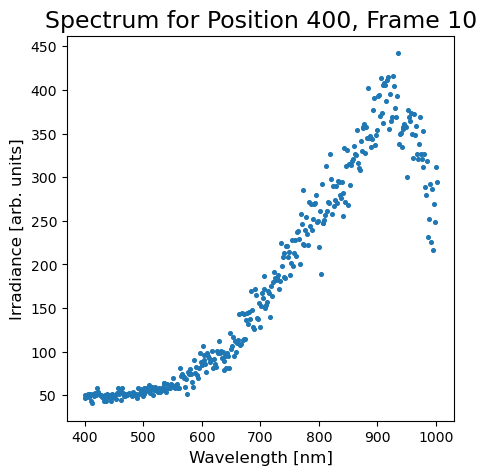

In [16]:
plt.figure(figsize=(5,5))
plt.scatter(wavelengths, cut_data[:,400,:][10], s=7)
plt.title("Spectrum for Position 400, Frame 10", fontsize=17)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Irradiance [arb. units]", fontsize=12)
# plt.yticks([])
plt.show()

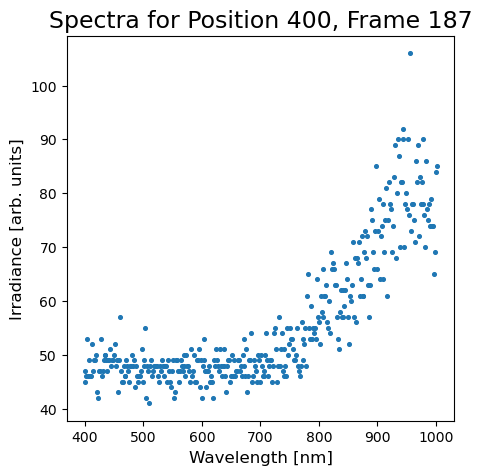

In [17]:
plt.figure(figsize=(5,5))
plt.scatter(wavelengths, cut_data[:,400,:][187], s=7)
plt.title("Spectra for Position 400, Frame 187", fontsize=17)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Irradiance [arb. units]", fontsize=12)
# plt.yticks([])
plt.show()

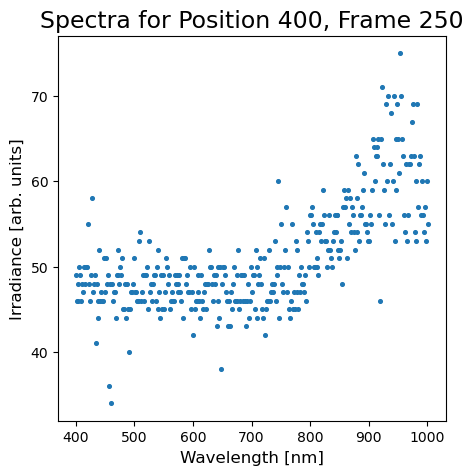

In [18]:
plt.figure(figsize=(5,5))
plt.scatter(wavelengths, cut_data[:,400,:][250], s=7)
plt.title("Spectra for Position 400, Frame 250", fontsize=17)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Irradiance [arb. units]", fontsize=12)
# plt.yticks([])
plt.show()

## Initial Guess 400 K

In [69]:
wl = wavelengths
row = cut_data[:,400,:]

  0%|          | 0/360 [00:00<?, ?it/s]

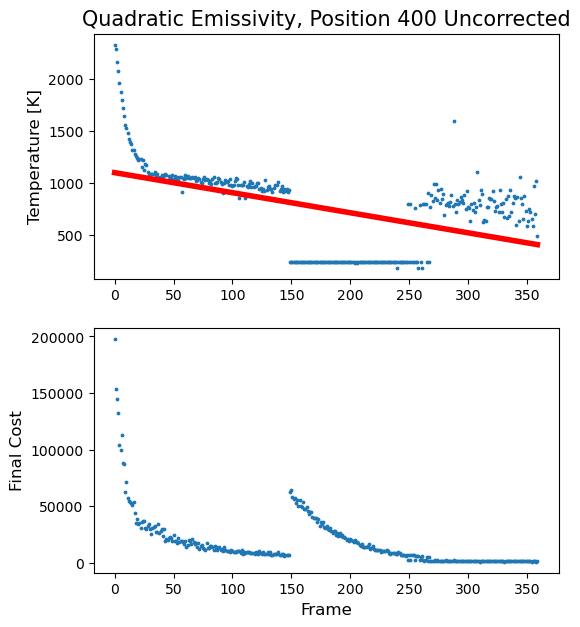

In [70]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 400])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Uncorrected", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

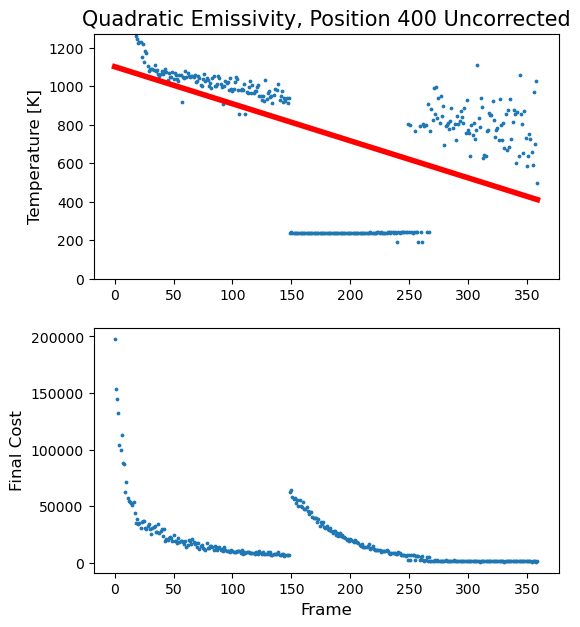

In [71]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Uncorrected", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1273])

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

## Initial Guess 500 K

  0%|          | 0/360 [00:00<?, ?it/s]

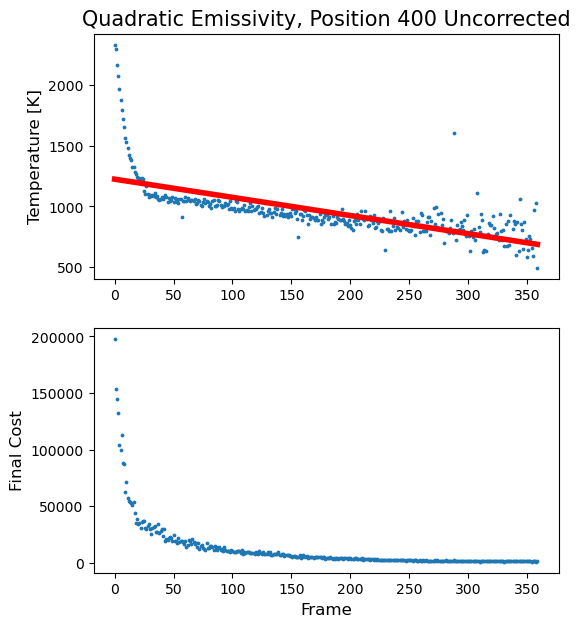

In [82]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 500])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Uncorrected", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

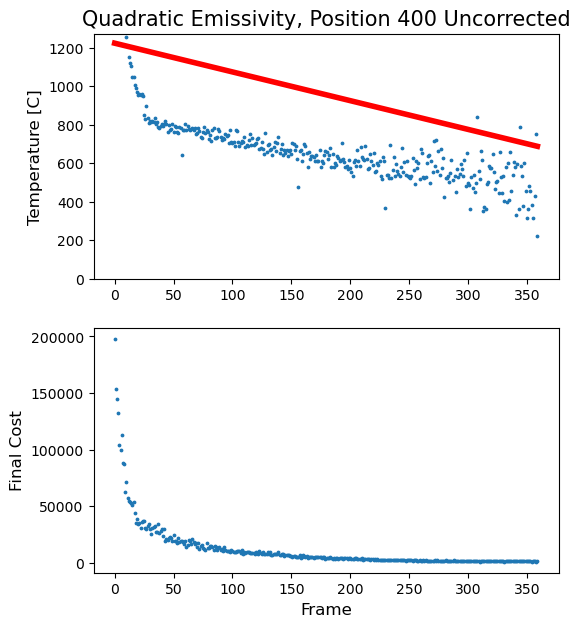

In [88]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Uncorrected", fontsize=15)

ax[0].scatter(x, np.array(Ts) - 273, s=3)
ax[0].set_ylabel("Temperature [C]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1273])

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

In [23]:
wl = wavelengths
row = cut_data[:,400,:]

  0%|          | 0/360 [00:00<?, ?it/s]

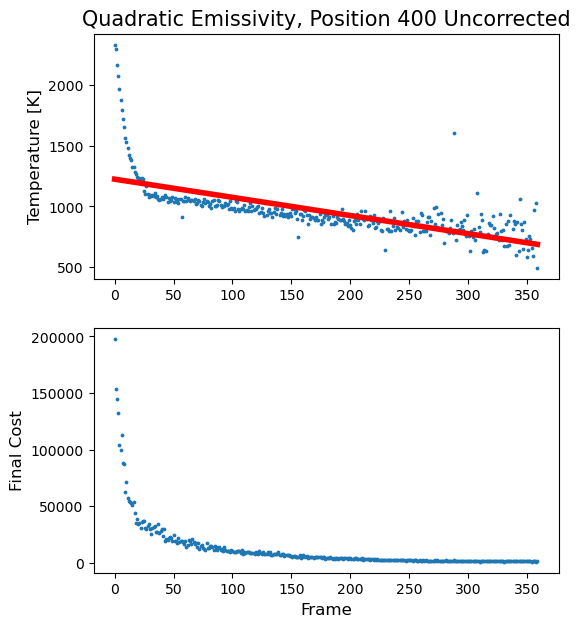

In [24]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 500])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Uncorrected", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

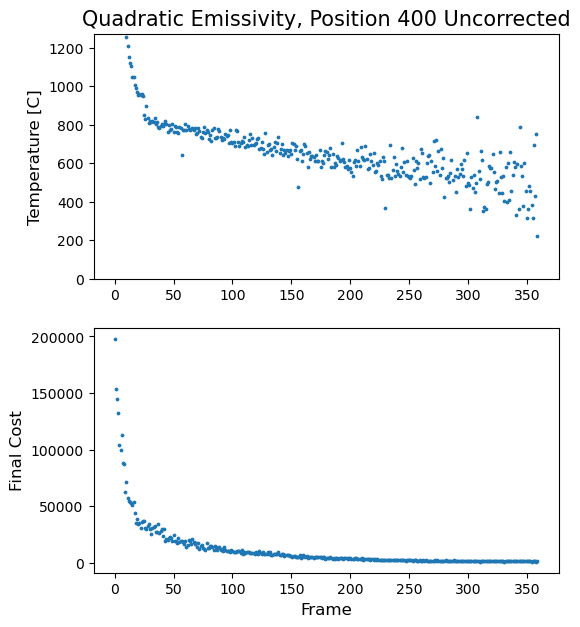

In [25]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Uncorrected", fontsize=15)

ax[0].scatter(x, np.array(Ts) - 273, s=3)
ax[0].set_ylabel("Temperature [C]", fontsize=12)
# model = LinearRegression()
# model.fit(x.reshape(-1,1), Ts)
# ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1273])

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

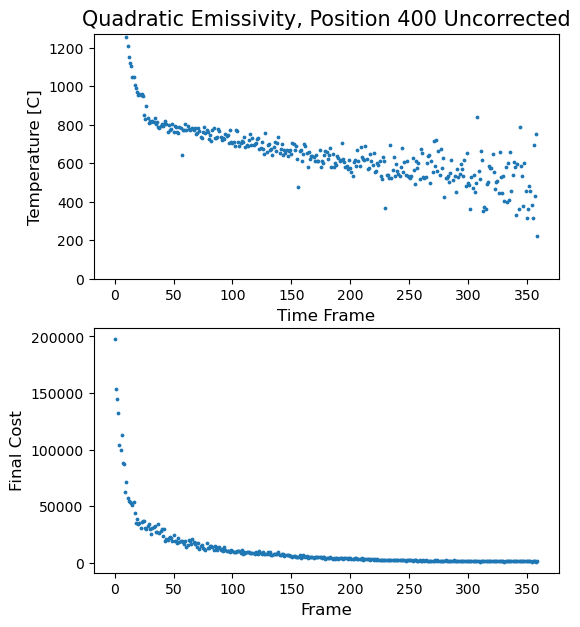

In [38]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Uncorrected", fontsize=15)

ax[0].scatter(x, np.array(Ts) - 273, s=3)
ax[0].set_ylabel("Temperature [C]", fontsize=12)
# model = LinearRegression()
# model.fit(x.reshape(-1,1), Ts)
# ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1273])
ax[0].set_xlabel("Time Frame", fontsize=12)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

## Position 600

In [12]:
wl = wavelengths
row = cut_data[:,600,:]

  0%|          | 0/360 [00:00<?, ?it/s]

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_32257/2706764598.py:3: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


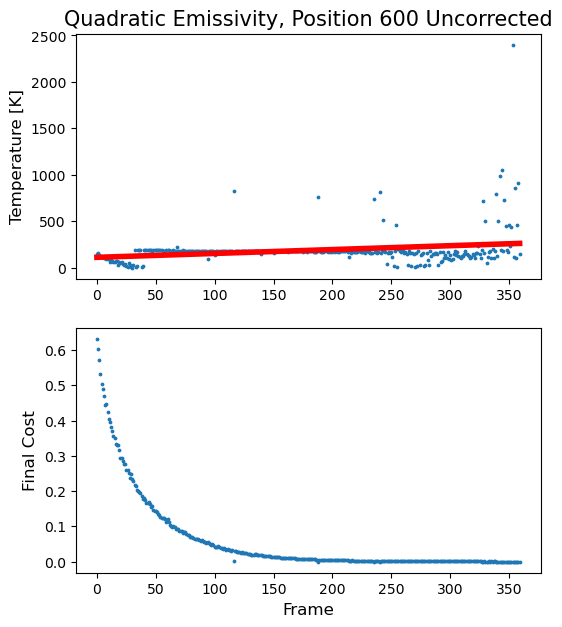

In [13]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 500])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 600 Uncorrected", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

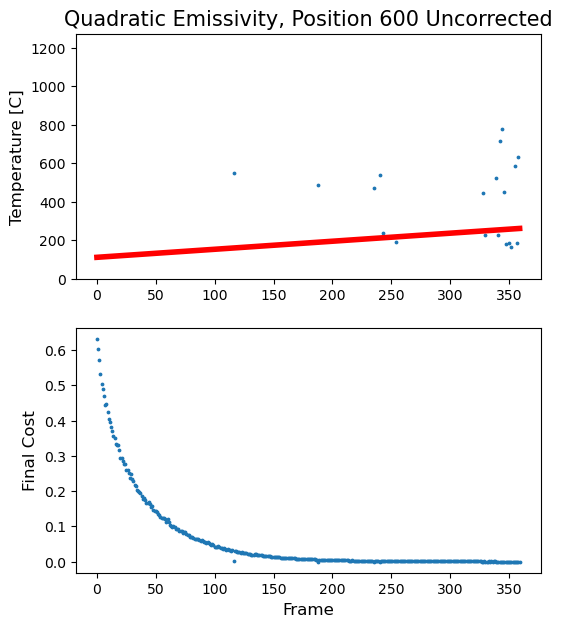

In [14]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 600 Uncorrected", fontsize=15)

ax[0].scatter(x, np.array(Ts) - 273, s=3)
ax[0].set_ylabel("Temperature [C]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1273])

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

  0%|          | 0/360 [00:00<?, ?it/s]

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_32257/2706764598.py:3: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


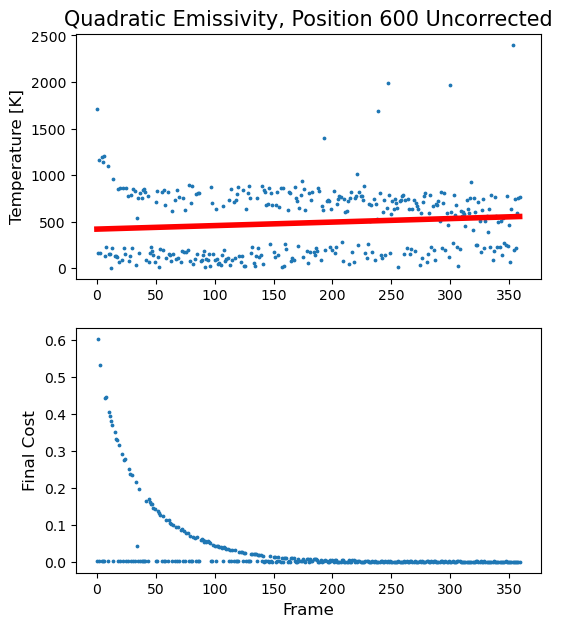

In [15]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 700])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 600 Uncorrected", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

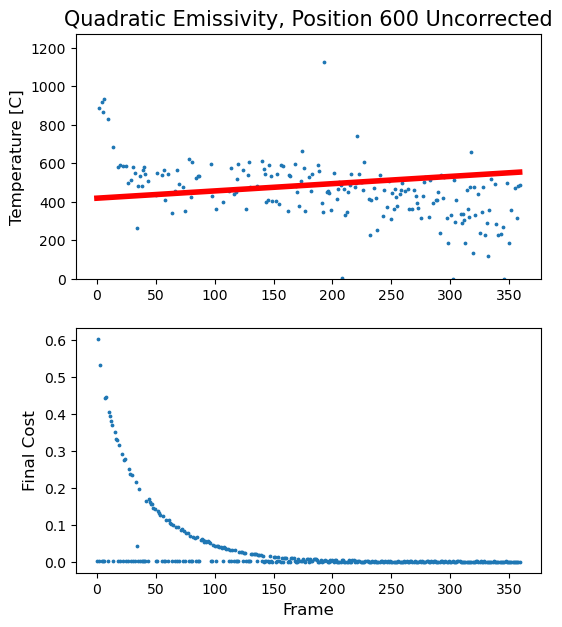

In [16]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 600 Uncorrected", fontsize=15)

ax[0].scatter(x, np.array(Ts) - 273, s=3)
ax[0].set_ylabel("Temperature [C]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1273])

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

  0%|          | 0/360 [00:00<?, ?it/s]

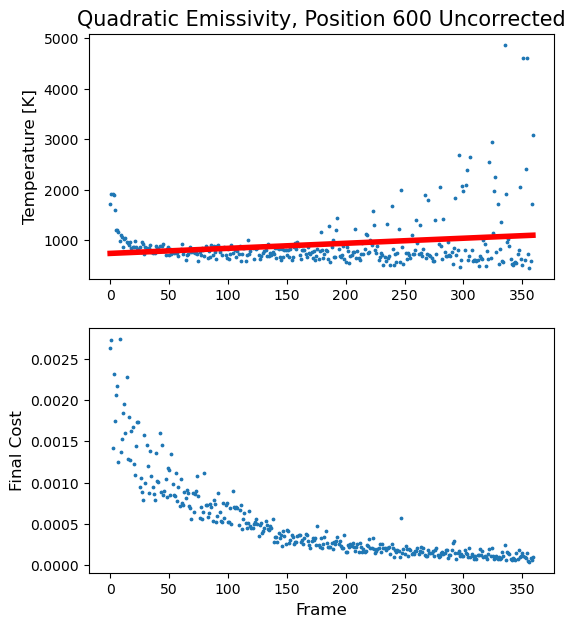

In [17]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 1000])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 600 Uncorrected", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

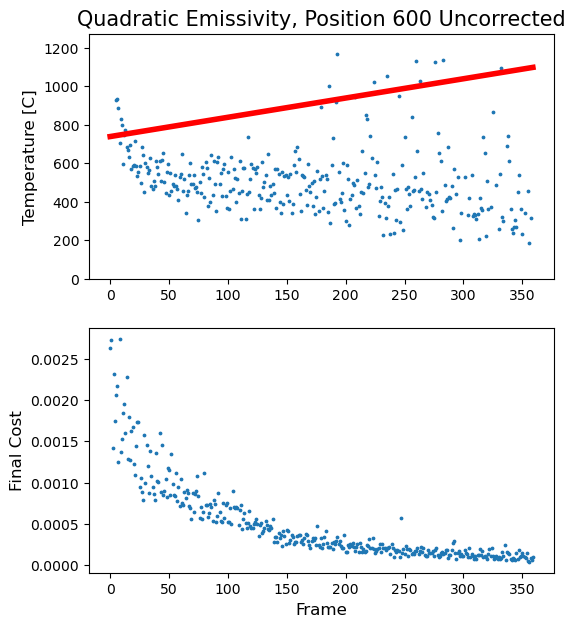

In [18]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 600 Uncorrected", fontsize=15)

ax[0].scatter(x, np.array(Ts) - 273, s=3)
ax[0].set_ylabel("Temperature [C]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1273])

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

## Full Data, Position 400

### Initial Guess 500 K

In [10]:
wl = wavelengths
row = data_tensor[:,400,:]

  0%|          | 0/523 [00:00<?, ?it/s]

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_17924/2706764598.py:3: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


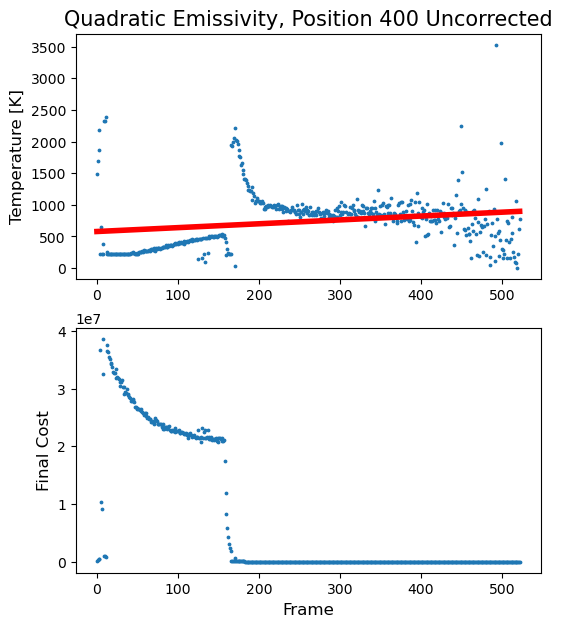

In [11]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 500])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Uncorrected", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

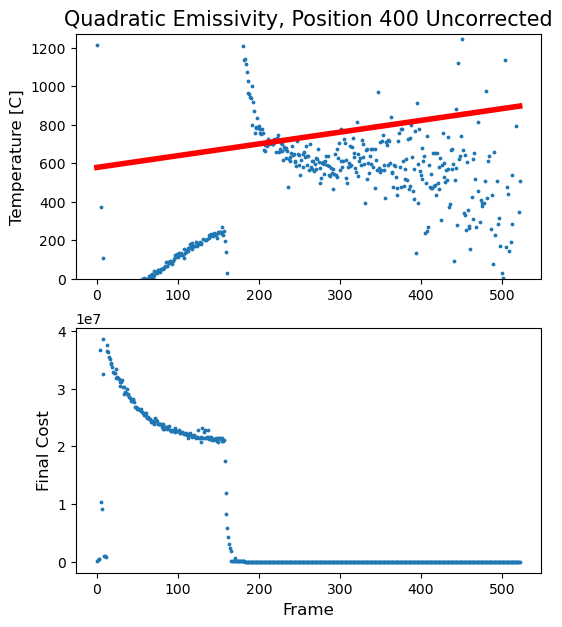

In [12]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400, Full Data Uncorrected", fontsize=15)

ax[0].scatter(x, np.array(Ts) - 273, s=3)
ax[0].set_ylabel("Temperature [C]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1273])

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

## Position 400 -- Split Corrected and Uncorrected

In [14]:
wl = wavelengths
row1 = corrected_data[:163,400,:]
row2 = data_tensor[163:,400,:]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_17924/2706764598.py:3: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


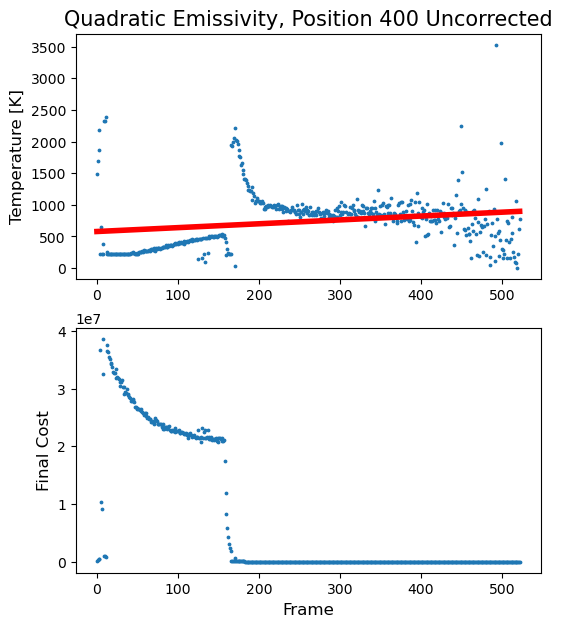

In [17]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row1))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 500])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

for frame_index in tqdm(range(len(row2))):
    data = row[frame_index + 163]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 500])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Uncorrected", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

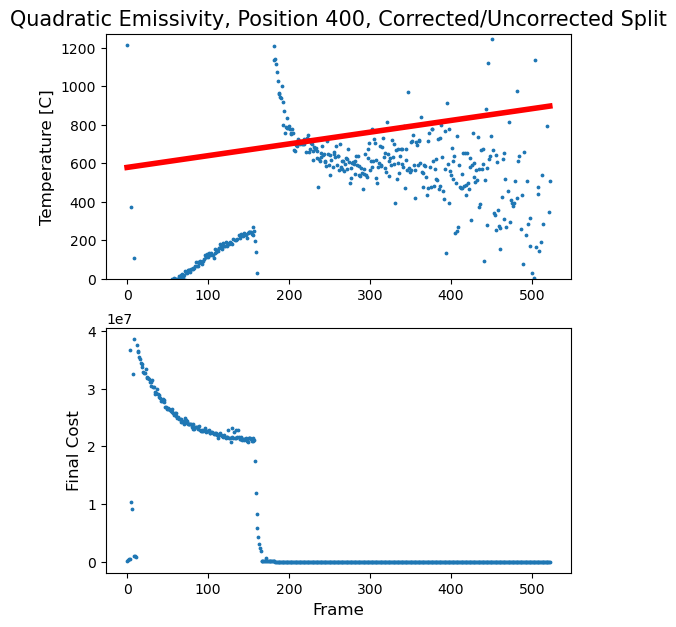

In [18]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400, Corrected/Uncorrected Split", fontsize=15)

ax[0].scatter(x, np.array(Ts) - 273, s=3)
ax[0].set_ylabel("Temperature [C]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1273])

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

### Initial Guess 700 K

In [19]:
wl = wavelengths
row1 = corrected_data[:163,400,:]
row2 = data_tensor[163:,400,:]

  0%|          | 0/163 [00:00<?, ?it/s]

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_17924/2706764598.py:3: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


  0%|          | 0/360 [00:00<?, ?it/s]

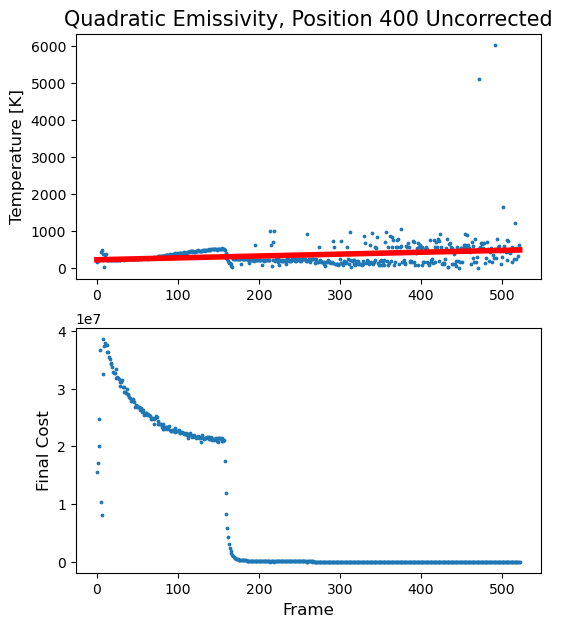

In [20]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row1))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 700])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

for frame_index in tqdm(range(len(row2))):
    data = row[frame_index + 163]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 700])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Uncorrected", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

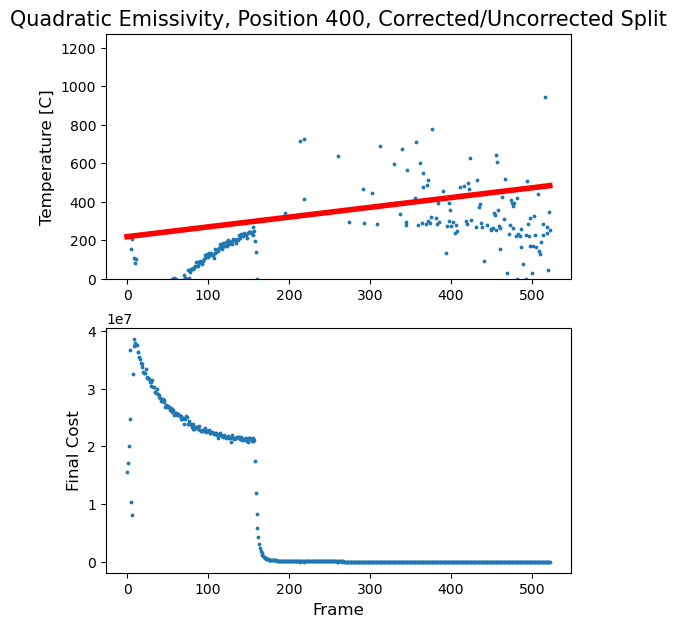

In [21]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400, Corrected/Uncorrected Split", fontsize=15)

ax[0].scatter(x, np.array(Ts) - 273, s=3)
ax[0].set_ylabel("Temperature [C]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1273])

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

## Individual Pixels

Optimal parameters: [-4.14873225e-09  4.58153986e+00 -4.40402755e+06  4.99740251e+01
  1.22710274e+03]
Final Cost: 34424.61861786222
Termination Status: 2


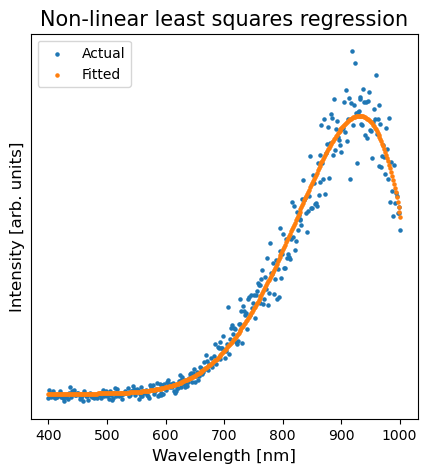

In [73]:
wl = wavelengths
data = cut_data[:,400,:][20]

# params = [a0, a1, a2, offset, T]
params0 = np.array([1, 1, 1, 0.1, 400])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

_ = curve_fit(wl, data, intensity, params0)

Optimal parameters: [ 1.81198257e-05 -1.74288176e+01  2.28681044e+01  4.70968159e+01
  1.07721120e+03]
Final Cost: 29689.488563698997
Termination Status: 2


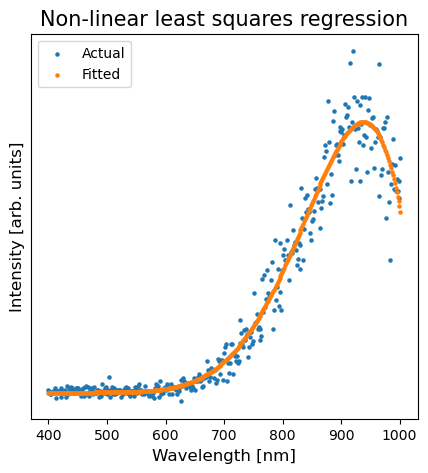

In [75]:
wl = wavelengths
data = cut_data[:,400,:][40]

# params = [a0, a1, a2, offset, T]
params0 = np.array([1, 1, 1, 0.1, 400])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

_ = curve_fit(wl, data, intensity, params0)

Optimal parameters: [ 1.34735288e-05 -1.29215271e+01  1.78036877e+00  4.67870095e+01
  1.07689769e+03]
Final Cost: 19004.136052976297
Termination Status: 3


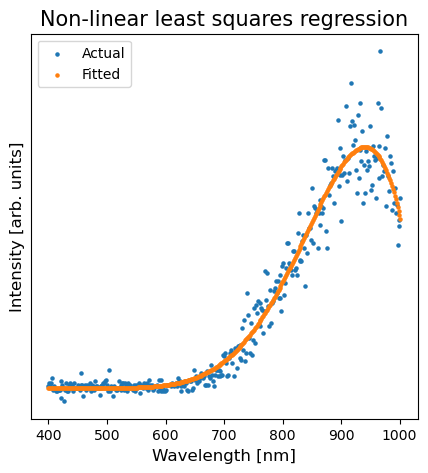

In [77]:
wl = wavelengths
data = cut_data[:,400,:][60]

# params = [a0, a1, a2, offset, T]
params0 = np.array([1, 1, 1, 0.1, 400])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

_ = curve_fit(wl, data, intensity, params0)

Optimal parameters: [ 5.77789460e-05 -5.60811179e+01  1.00414499e+02  4.74362938e+01
  9.19960889e+02]
Final Cost: 6364.96306138403
Termination Status: 2


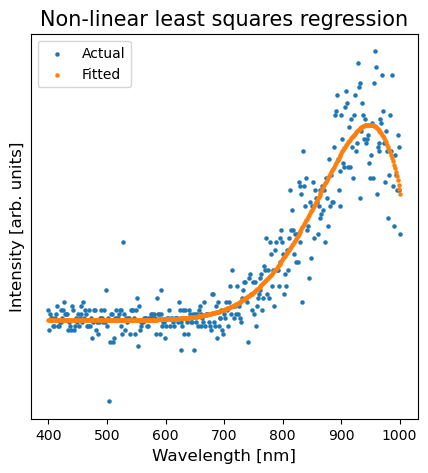

In [79]:
wl = wavelengths
data = cut_data[:,400,:][150]

# params = [a0, a1, a2, offset, T]
params0 = np.array([1, 1, 1, 0.1, 500])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

_ = curve_fit(wl, data, intensity, params0)

Optimal parameters: [ 1.38344534e-04 -1.35082021e+02  1.26766628e+02  4.75775121e+01
  8.49001670e+02]
Final Cost: 3869.1263760904676
Termination Status: 2


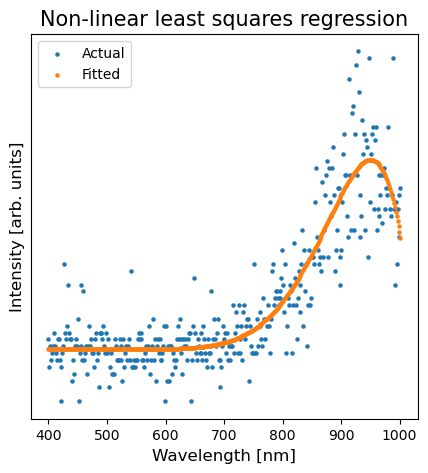

In [80]:
wl = wavelengths
data = cut_data[:,400,:][200]

# params = [a0, a1, a2, offset, T]
params0 = np.array([1, 1, 1, 0.1, 500])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

_ = curve_fit(wl, data, intensity, params0)

Optimal parameters: [ 1.06446277e-04 -1.02093870e+02  5.46969794e+01  4.75803977e+01
  7.81009004e+02]
Final Cost: 1521.7921643279062
Termination Status: 3


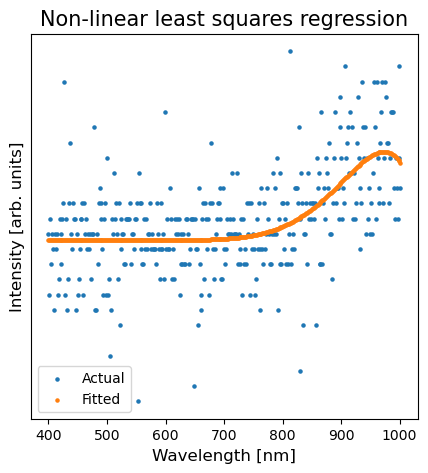

In [81]:
wl = wavelengths
data = cut_data[:,400,:][325]

# params = [a0, a1, a2, offset, T]
params0 = np.array([1, 1, 1, 0.1, 500])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

_ = curve_fit(wl, data, intensity, params0)

## Averaging Space

In [52]:
def compress_space(data, start_idx, end_idx):
    return np.divide(np.sum(cut_data[:,start_idx:end_idx,:],axis=1), end_idx-start_idx)

### 10 Positions

In [55]:
wl = wavelengths
row = compress_space(cut_data, 400, 410)

  0%|          | 0/360 [00:00<?, ?it/s]

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_34948/2706764598.py:3: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


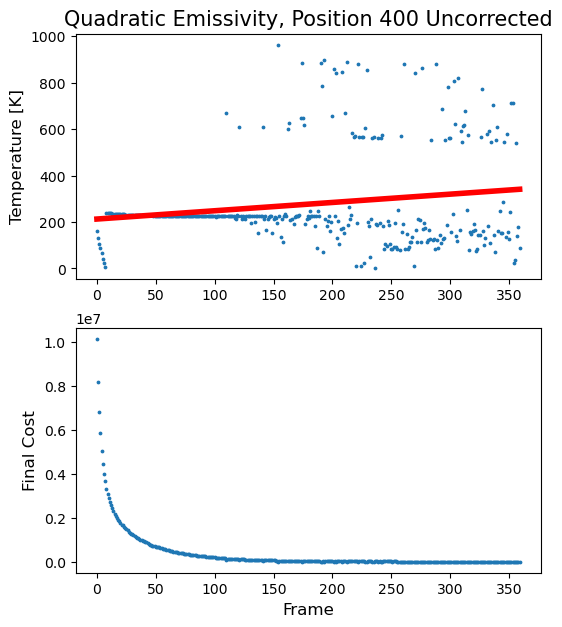

In [57]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 700])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Uncorrected", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

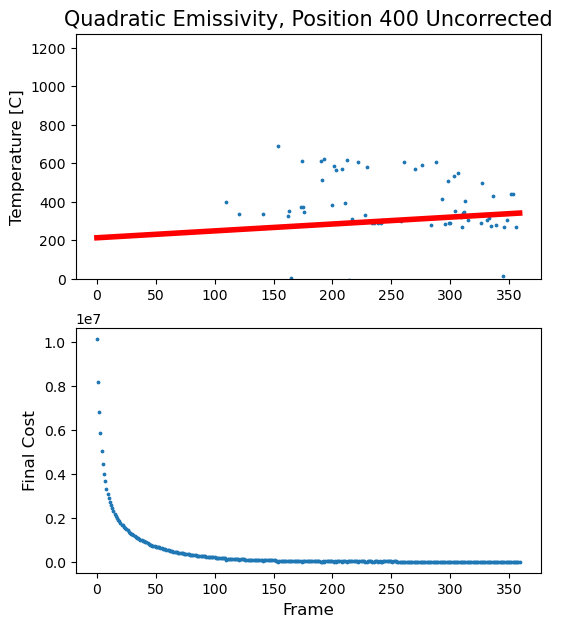

In [58]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Uncorrected", fontsize=15)

ax[0].scatter(x, np.array(Ts) - 273, s=3)
ax[0].set_ylabel("Temperature [C]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1273])

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

  0%|          | 0/360 [00:00<?, ?it/s]

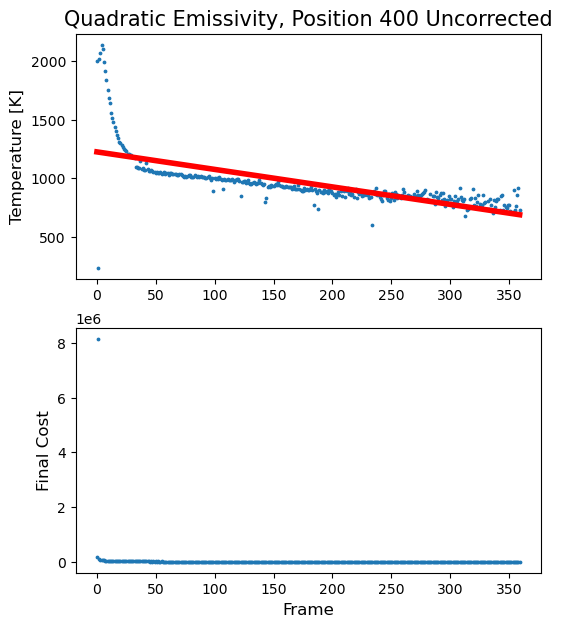

In [59]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 500])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Uncorrected", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

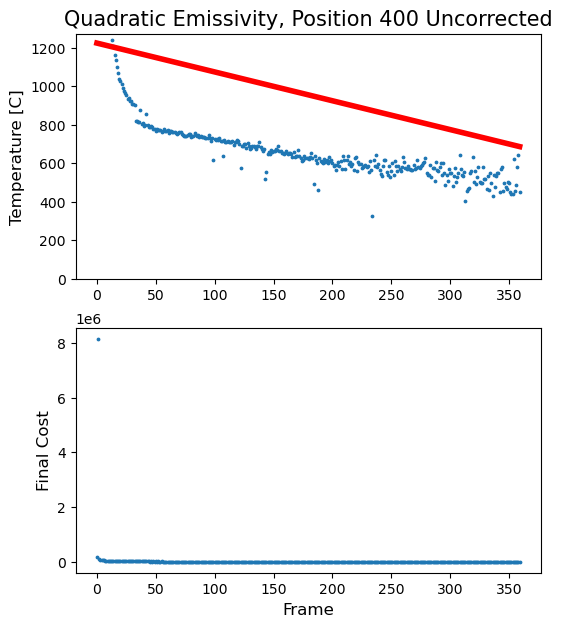

In [60]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Uncorrected", fontsize=15)

ax[0].scatter(x, np.array(Ts) - 273, s=3)
ax[0].set_ylabel("Temperature [C]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1273])

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

### 30 Positions

In [61]:
wl = wavelengths
row = compress_space(cut_data, 400, 430)

  0%|          | 0/360 [00:00<?, ?it/s]

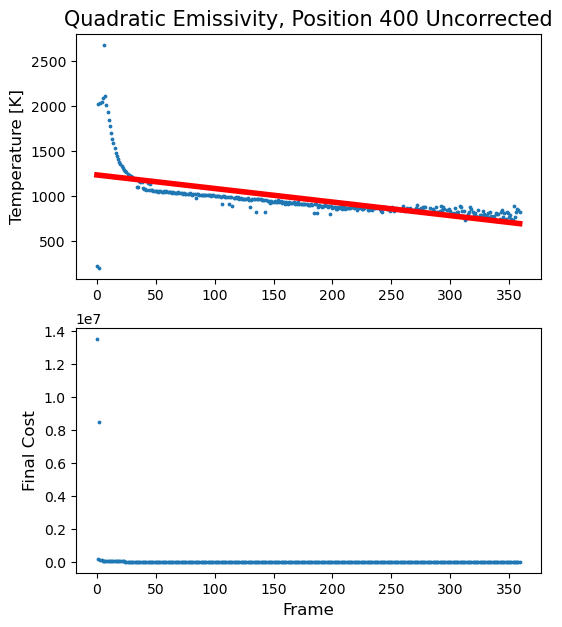

In [62]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 500])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Uncorrected", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

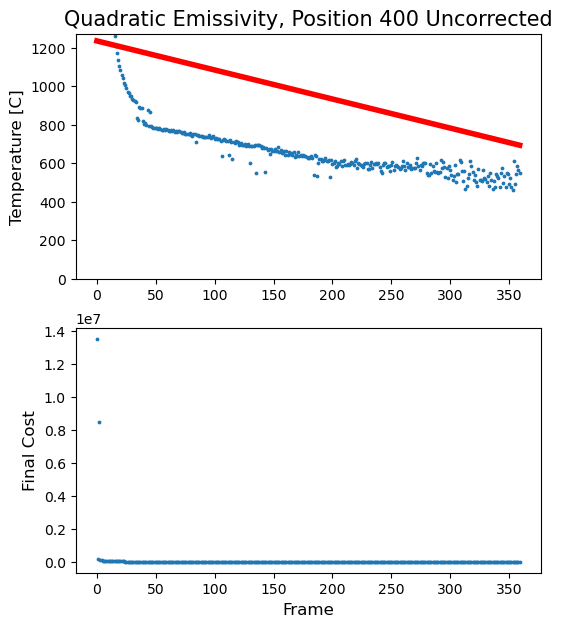

In [63]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400 Uncorrected", fontsize=15)

ax[0].scatter(x, np.array(Ts) - 273, s=3)
ax[0].set_ylabel("Temperature [C]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1273])

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

### 50 Positions

In [66]:
wl = wavelengths
row = compress_space(cut_data, 400, 450)

  0%|          | 0/360 [00:00<?, ?it/s]

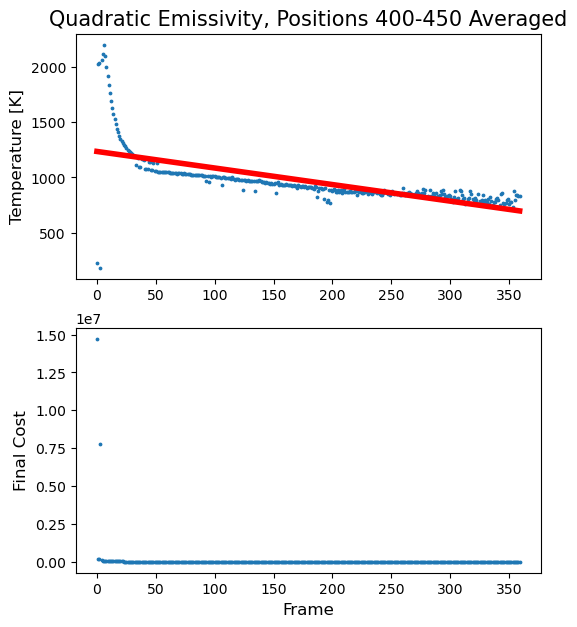

In [67]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 500])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Positions 400-450 Averaged", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

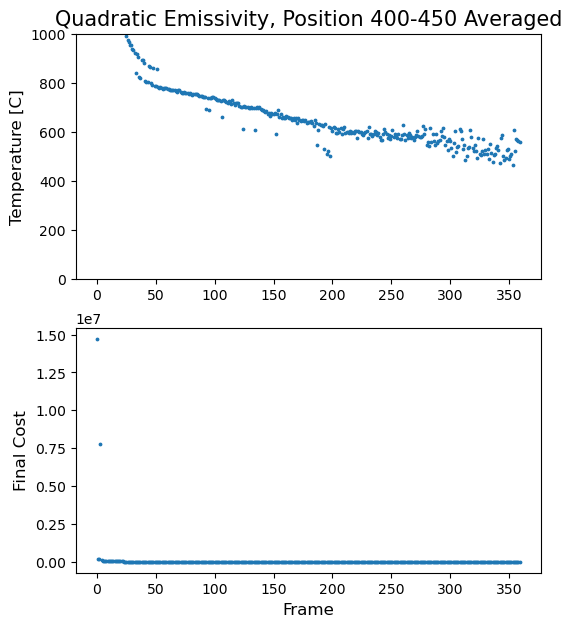

In [68]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400-450 Averaged", fontsize=15)

ax[0].scatter(x, np.array(Ts) - 273, s=3)
ax[0].set_ylabel("Temperature [C]", fontsize=12)
# model = LinearRegression()
# model.fit(x.reshape(-1,1), Ts)
# ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1000])

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

### 100 Positions

In [69]:
wl = wavelengths
row = compress_space(cut_data, 400, 500)

  0%|          | 0/360 [00:00<?, ?it/s]

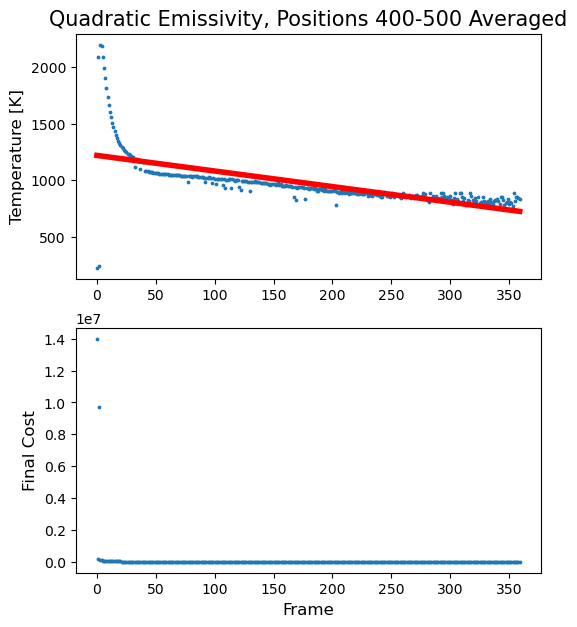

In [70]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0, 500])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Positions 400-500 Averaged", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

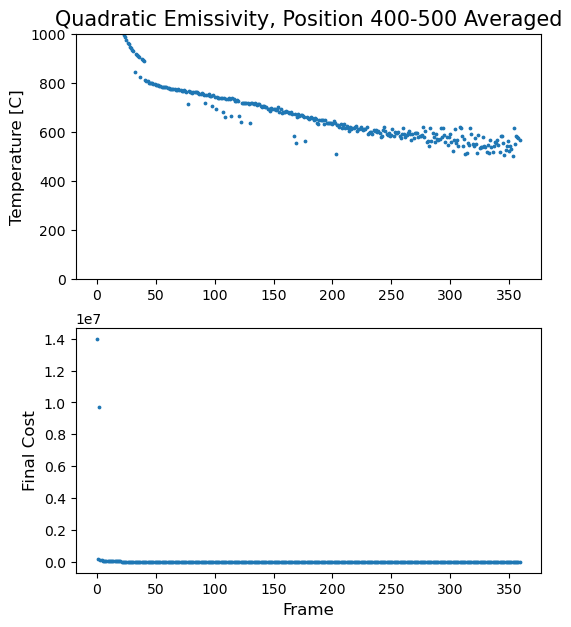

In [71]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, Position 400-500 Averaged", fontsize=15)

ax[0].scatter(x, np.array(Ts) - 273, s=3)
ax[0].set_ylabel("Temperature [C]", fontsize=12)
# model = LinearRegression()
# model.fit(x.reshape(-1,1), Ts)
# ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)
ax[0].set_ylim([0, 1000])

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

### Averaged Spectra

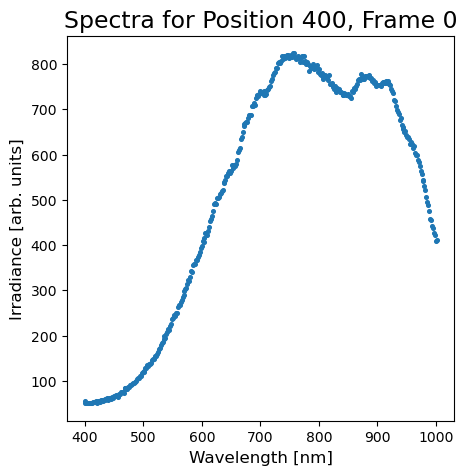

In [81]:
plt.figure(figsize=(5,5))
plt.scatter(wavelengths, row[0], s=7)
plt.title("Spectra for Position 400, Frame 0", fontsize=17)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Irradiance [arb. units]", fontsize=12)
# plt.yticks([])
plt.show()

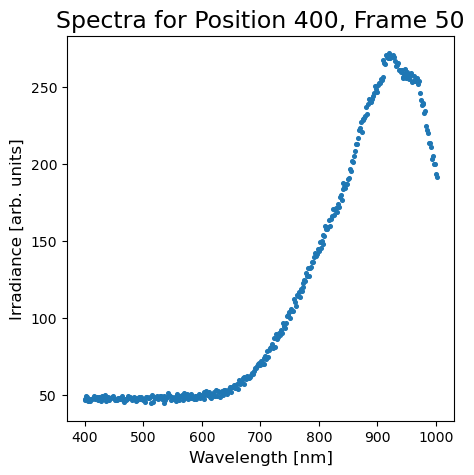

In [80]:
plt.figure(figsize=(5,5))
plt.scatter(wavelengths, row[50], s=7)
plt.title("Spectra for Position 400, Frame 50", fontsize=17)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Irradiance [arb. units]", fontsize=12)
# plt.yticks([])
plt.show()

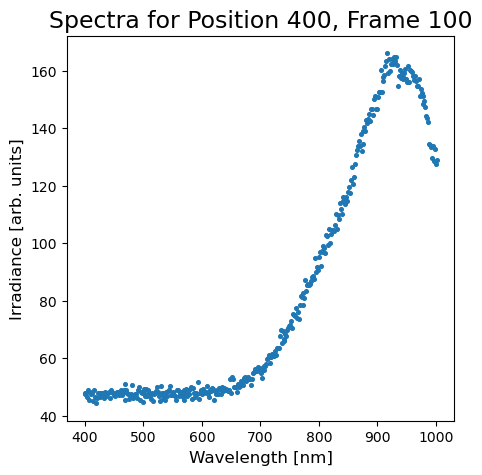

In [79]:
plt.figure(figsize=(5,5))
plt.scatter(wavelengths, row[100], s=7)
plt.title("Spectra for Position 400, Frame 100", fontsize=17)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Irradiance [arb. units]", fontsize=12)
# plt.yticks([])
plt.show()

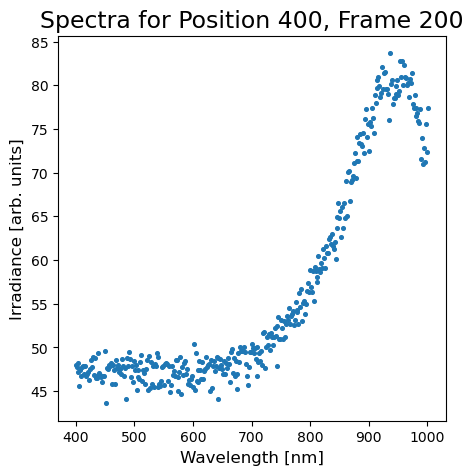

In [78]:
plt.figure(figsize=(5,5))
plt.scatter(wavelengths, row[200], s=7)
plt.title("Spectra for Position 400, Frame 200", fontsize=17)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Irradiance [arb. units]", fontsize=12)
# plt.yticks([])
plt.show()

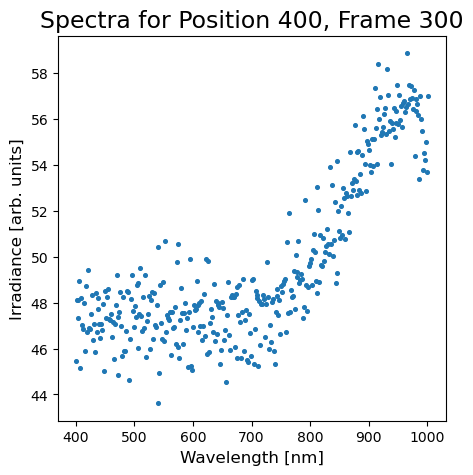

In [77]:
plt.figure(figsize=(5,5))
plt.scatter(wavelengths, row[300], s=7)
plt.title("Spectra for Position 400, Frame 300", fontsize=17)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Irradiance [arb. units]", fontsize=12)
# plt.yticks([])
plt.show()

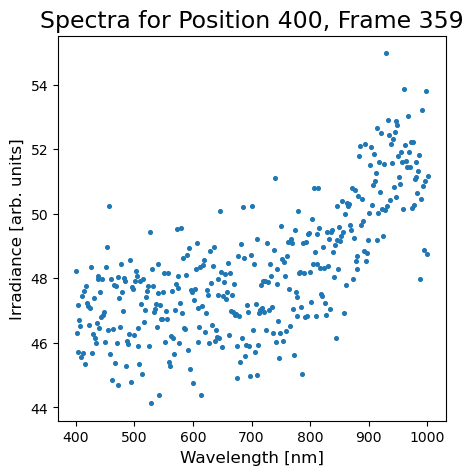

In [84]:
plt.figure(figsize=(5,5))
plt.scatter(wavelengths, row[359], s=7)
plt.title("Spectra for Position 400, Frame 359", fontsize=17)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Irradiance [arb. units]", fontsize=12)
# plt.yticks([])
plt.show()